# Setup

In [1]:
import gc
gc.enable()

import warnings
warnings.filterwarnings(category=FutureWarning, action='ignore')
warnings.filterwarnings(category=UserWarning, action='ignore')

import time
import joblib
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis
)
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier,
    HistGradientBoostingClassifier
)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold
)
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    roc_auc_score,
    confusion_matrix
)

SEED = 2024

# Data preparation

In [2]:
data = pd.read_csv('/kaggle/input/predict-online-course-engagement-dataset/online_course_engagement_data.csv')

In [3]:
TARGET = 'CourseCompletion'
features = [f for f in data.columns if f not in ('UserID', TARGET)]
cat_features = ['DeviceType', 'CourseCategory']
num_features = [f for f in features if f not in cat_features]

### Preprocessing

In [4]:
def preprocess_dataset(df):
    # remove duplicates
    df = df.drop_duplicates(ignore_index=True)
    
    # one-hot encoding nominal variable
    df = pd.get_dummies(df, columns=['CourseCategory'], dtype='int8')
    
    df['DeviceType'] = df['DeviceType'].astype('int8')
    
    # binarize numerical features
    df['time_spent_above_threshold'] = (df['TimeSpentOnCourse'] > 20).astype('int8')
    df['num_videos_above_threshold'] = (df['NumberOfVideosWatched'] > 5).astype('int8')
    df['num_quizzes_above_threshold'] = (df['NumberOfQuizzesTaken'] > 3).astype('int8')
    df['quiz_scores_above_threshold'] = (df['QuizScores'] > 68).astype('int8')
    df['completion_above_threshold'] = (df['CompletionRate'] > 60).astype('int8')
    
    return df

In [5]:
data = preprocess_dataset(data.copy())

### Feature sets

Generated in: [Online Course Engagement - Logistic Regression](https://www.kaggle.com/code/sid4ds/online-course-engagement-logistic-regression)

In [6]:
original_features = [
    'TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 
    'QuizScores', 'CompletionRate', 'DeviceType', 'CourseCategory_Arts', 
    'CourseCategory_Business', 'CourseCategory_Health', 
    'CourseCategory_Programming', 'CourseCategory_Science'
]

extended_features = [
    'TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 
    'QuizScores', 'CompletionRate', 'DeviceType', 'CourseCategory_Arts', 
    'CourseCategory_Business', 'CourseCategory_Health', 
    'CourseCategory_Programming', 'CourseCategory_Science', 
    'time_spent_above_threshold', 'num_videos_above_threshold', 
    'num_quizzes_above_threshold', 'quiz_scores_above_threshold', 
    'completion_above_threshold'
]

binary_features = [
    'DeviceType', 'CourseCategory_Arts', 'CourseCategory_Business', 
    'CourseCategory_Health', 'CourseCategory_Programming', 
    'CourseCategory_Science', 'time_spent_above_threshold', 
    'num_videos_above_threshold', 'num_quizzes_above_threshold', 
    'quiz_scores_above_threshold', 'completion_above_threshold'
]

minimal_features = [
    'time_spent_above_threshold', 'num_videos_above_threshold', 
    'num_quizzes_above_threshold', 'quiz_scores_above_threshold', 
    'completion_above_threshold'
]

In [7]:
feature_sets = {
    'Original': original_features,
    'Extended': extended_features,
    'Binary': binary_features,
    'Minimal': minimal_features
}

### Holdout set for model-testing
(exactly the same as used in previous modeling experiments)

In [8]:
train, test, _, _ = train_test_split(
    data, data[TARGET],
    stratify=data[TARGET],
    test_size=0.1,  # same size
    shuffle=True,
    random_state=SEED  # same sampling
)

# Modeling framework

In [9]:
def cross_validate(estimator, feature_set, num_folds=9):
    global train, TARGET
    
    scores_auc, scores_acc = [], []
    X, y = train[feature_set], train[TARGET]
    
    cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)
    for fold, (train_ids, val_ids) in enumerate(cv.split(X, y)):
        X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
        X_val, y_val = X.iloc[val_ids], y.iloc[val_ids]
        
        model = clone(estimator)
        model.fit(X_train, y_train)
        probs = model.predict_proba(X_val)[:, 1]
        scores_auc.append(roc_auc_score(y_val, probs))
        preds = model.predict(X_val)
        scores_acc.append(accuracy_score(y_val, preds))
        
    scores_df = pd.DataFrame(
        data={'Accuracy': scores_acc, 'ROC-AUC': scores_auc}, 
        index=[f'Fold #{i+1}' for i in range(9)]
    )
    display(scores_df.T)

In [10]:
def refit_full_and_evaluate(model, feature_set):
    global train, TARGET
    
    model.fit(train[feature_set], train[TARGET])
    probs = model.predict_proba(test[feature_set])[:, 1]
    preds = model.predict(test[feature_set])
    
    accuracy = accuracy_score(test[TARGET], preds)
    auc = roc_auc_score(test[TARGET], probs)
    print(f'|| Accuracy: {accuracy:.4f} || ROC-AUC: {auc:.4f} ||\n')
    
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_title('Normalized Confusion Matrix')
    sns.heatmap(
        data=confusion_matrix(test[TARGET], preds, normalize='true'),
        annot=True, fmt='.4f', linewidths=0.1, cmap=plt.cm.Blues
    )
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.show()
    
    return model

In [11]:
def save_model(model, config, notebook='02'):
    save_path = f'{notebook}_{config}.joblib'
    joblib.dump(model, save_path)

In [12]:
def run_experiment(estimator, model_name, save=True):
    global feature_sets
    
    for fname, fset in feature_sets.items():
        print('\n', '-'*25, fname, '-'*25)
        start_time = time.time()
        print('Cross-validation:')
        cross_validate(estimator, fset)
        print('Refit to full training data and evaluate:\n')
        model = refit_full_and_evaluate(estimator, fset)
        end_time = time.time()
        print(f'\n(Time taken: {end_time - start_time:.2f} secs)')
        
        if save:
            save_model(model, f'{model_name}_{fname}')

# Discriminant Analysis

## Linear

In [13]:
model = make_pipeline(
    StandardScaler(), 
    LinearDiscriminantAnalysis(solver='svd', tol=1e-4)
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.7823,0.7934,0.7956,0.7857,0.7808,0.7833,0.8030,0.7968,0.8091
ROC-AUC,0.8569,0.8583,0.8686,0.8707,0.8581,0.8576,0.8858,0.8720,0.8921


Refit to full training data and evaluate:

|| Accuracy: 0.7798 || ROC-AUC: 0.8665 ||



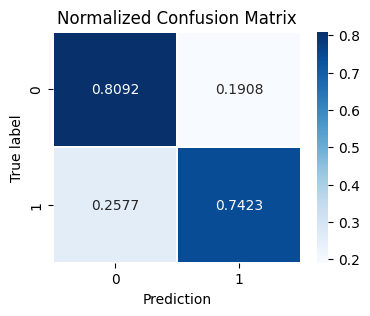


(Time taken: 0.69 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9557,0.9398,0.9466,0.9482,0.9546,0.9419,0.9527,0.9626,0.9644


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9597 ||



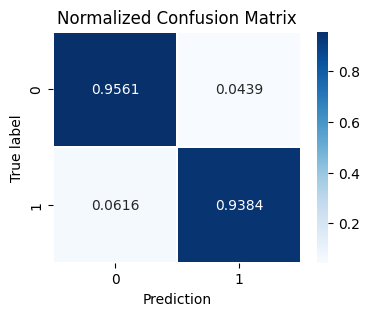


(Time taken: 1.13 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9461,0.9325,0.9377,0.9444,0.9531,0.9367,0.9447,0.9567,0.9545


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9514 ||



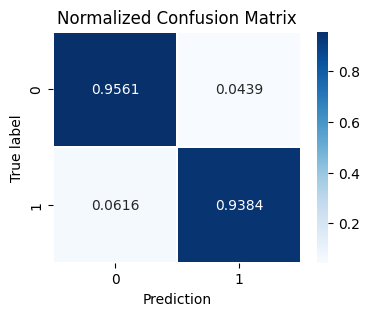


(Time taken: 0.59 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9464,0.9295,0.9385,0.9448,0.9536,0.9377,0.9498,0.9562,0.9538


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9517 ||



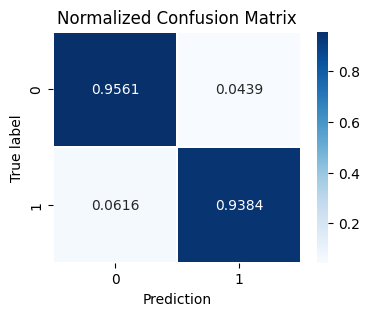


(Time taken: 0.42 secs)


In [14]:
run_experiment(model, 'lda')

## Quadratic

In [15]:
model = make_pipeline(
    StandardScaler(),
    QuadraticDiscriminantAnalysis(reg_param=0.25, tol=1e-4)
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.8069,0.8020,0.8165,0.8276,0.8140,0.8067,0.8276,0.8165,0.8424
ROC-AUC,0.8803,0.8768,0.8882,0.8933,0.8775,0.8814,0.9029,0.8925,0.9123


Refit to full training data and evaluate:

|| Accuracy: 0.8093 || ROC-AUC: 0.8883 ||



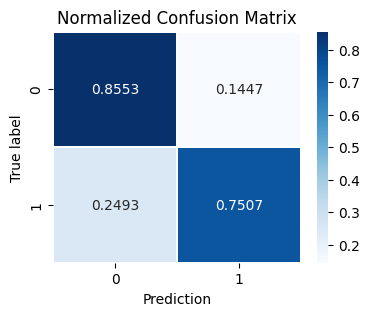


(Time taken: 0.67 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9274,0.9188,0.9335,0.9261,0.9126,0.9249,0.9249,0.9409,0.9483
ROC-AUC,0.9476,0.9320,0.9460,0.9428,0.9428,0.9442,0.9433,0.9578,0.9697


Refit to full training data and evaluate:

|| Accuracy: 0.9348 || ROC-AUC: 0.9593 ||



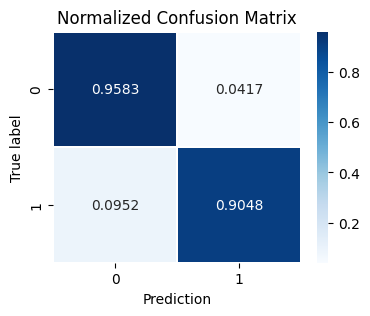


(Time taken: 0.70 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9250,0.9139,0.9273,0.9224,0.9150,0.9200,0.9236,0.9372,0.9421
ROC-AUC,0.9453,0.9346,0.9443,0.9344,0.9458,0.9428,0.9366,0.9564,0.9661


Refit to full training data and evaluate:

|| Accuracy: 0.9287 || ROC-AUC: 0.9568 ||



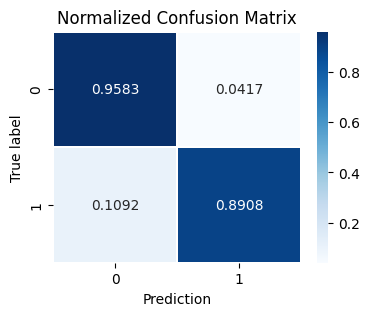


(Time taken: 0.62 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9250,0.9139,0.9273,0.9224,0.9150,0.9200,0.9236,0.9372,0.9421
ROC-AUC,0.9457,0.9315,0.9432,0.9337,0.9442,0.9438,0.9384,0.9561,0.9659


Refit to full training data and evaluate:

|| Accuracy: 0.9287 || ROC-AUC: 0.9561 ||



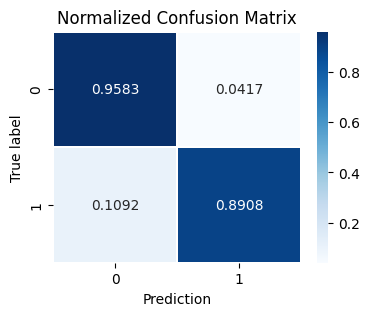


(Time taken: 0.36 secs)


In [16]:
run_experiment(model, 'qda')

# Naive Bayes - BernoulliNB
(Works only for binary features)

In [17]:
bnb_model = BernoulliNB(alpha=0.5)

------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9491,0.9340,0.9417,0.9437,0.9503,0.9366,0.9422,0.9564,0.9604


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9582 ||



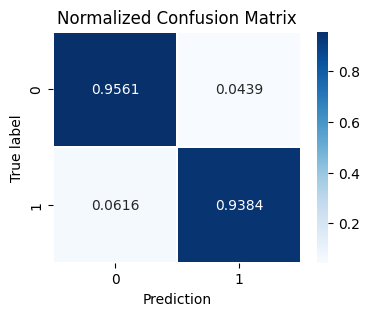


(Time taken: 0.39 secs)


In [18]:
print('-'*25, 'Binary', '-'*25)
start_time = time.time()
print('Cross-validation:')
cross_validate(bnb_model, binary_features)
print('Refit to full training data and evaluate:\n')
bnb_model = refit_full_and_evaluate(bnb_model, binary_features)
end_time = time.time()
print(f'\n(Time taken: {end_time - start_time:.2f} secs)')

save_model(bnb_model, 'bernoullinb_Binary')

------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9467,0.9321,0.9406,0.9436,0.9459,0.9365,0.9468,0.9568,0.9588


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9546 ||



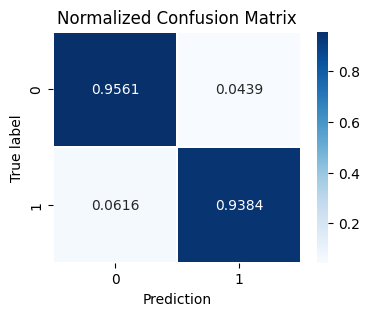


(Time taken: 0.39 secs)


In [19]:
print('-'*25, 'Minimal', '-'*25)
start_time = time.time()
print('Cross-validation:')
cross_validate(bnb_model, minimal_features)
print('Refit to full training data and evaluate:\n')
model = refit_full_and_evaluate(bnb_model, minimal_features)
end_time = time.time()
print(f'\n(Time taken: {end_time - start_time:.2f} secs)')

save_model(bnb_model, 'bernoullinb_Minimal')

# K-Nearest Neighbors

In [20]:
model = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(
        n_neighbors=10, 
        weights='distance', 
        n_jobs=-1
    )
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.8561,0.8475,0.8707,0.8695,0.8448,0.8436,0.8670,0.8571,0.8793
ROC-AUC,0.9188,0.9117,0.9176,0.9200,0.9193,0.9080,0.9246,0.9231,0.9392


Refit to full training data and evaluate:

|| Accuracy: 0.8438 || ROC-AUC: 0.9146 ||



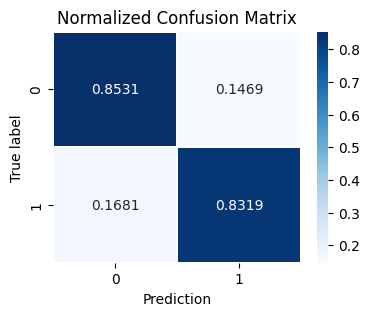


(Time taken: 1.52 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9422,0.9299,0.9446,0.9409,0.9433,0.9372,0.9360,0.9557,0.9557
ROC-AUC,0.9441,0.9380,0.9500,0.9467,0.9476,0.9339,0.9536,0.9605,0.9573


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9462 ||



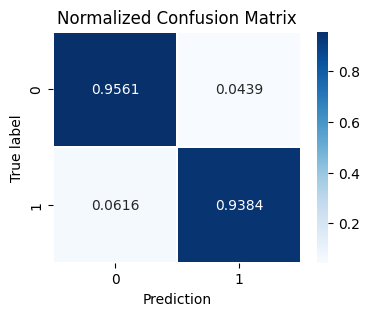


(Time taken: 0.81 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9397,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9427,0.9329,0.9475,0.9438,0.9497,0.9309,0.9446,0.9599,0.9608


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9452 ||



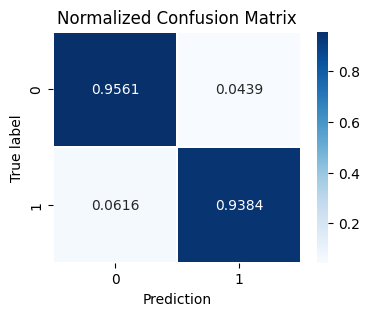


(Time taken: 1.63 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9471,0.9279,0.9456,0.9440,0.9434,0.9381,0.9460,0.9545,0.9546


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9496 ||



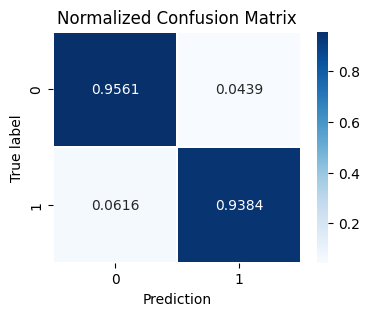


(Time taken: 1.15 secs)


In [21]:
run_experiment(model, 'knn')

# Decision Tree

In [22]:
model = DecisionTreeClassifier(
    max_depth=6, 
    class_weight='balanced',
    random_state=SEED
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9545,0.9397,0.9495,0.9520,0.9569,0.9470,0.9507,0.9643,0.9704
ROC-AUC,0.9444,0.9388,0.9451,0.9562,0.9584,0.9413,0.9486,0.9621,0.9720


Refit to full training data and evaluate:

|| Accuracy: 0.9582 || ROC-AUC: 0.9641 ||



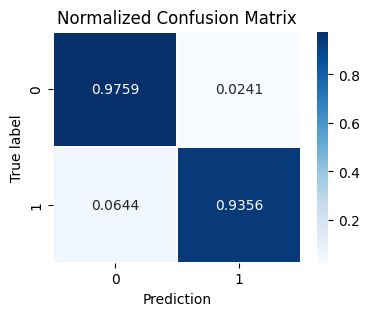


(Time taken: 0.62 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9545,0.941,0.9495,0.9520,0.9569,0.9483,0.9520,0.9643,0.9704
ROC-AUC,0.9444,0.941,0.9451,0.9562,0.9584,0.9420,0.9506,0.9621,0.9720


Refit to full training data and evaluate:

|| Accuracy: 0.9594 || ROC-AUC: 0.9660 ||



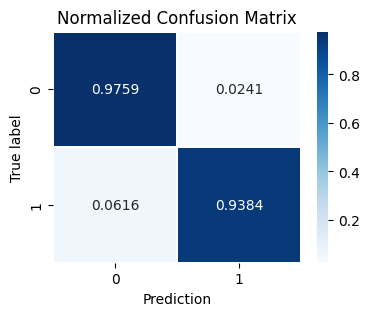


(Time taken: 0.65 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9454,0.9327,0.9496,0.9436,0.9456,0.9370,0.9440,0.9608,0.9583


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9503 ||



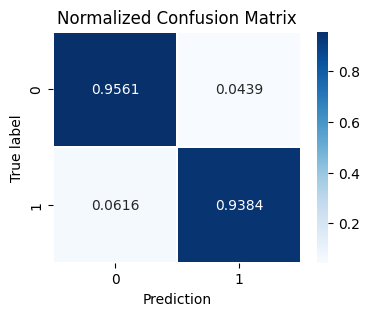


(Time taken: 0.44 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9507,0.9308,0.9470,0.9465,0.9430,0.9418,0.9546,0.9592,0.9624


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9527 ||



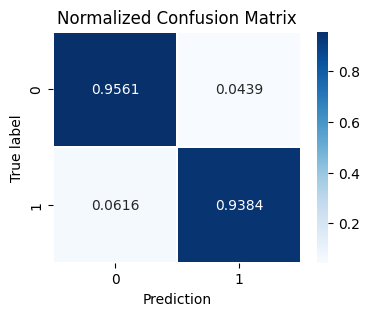


(Time taken: 0.38 secs)


In [23]:
run_experiment(model, 'dtree')

# Random Forest

In [24]:
model = RandomForestClassifier(
    n_estimators=150, 
    max_depth=6, 
    class_weight='balanced',
    random_state=SEED,
    n_jobs=1
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9569,0.9422,0.9557,0.9557,0.9544,0.9483,0.9594,0.9643,0.9704
ROC-AUC,0.9588,0.9364,0.9465,0.9444,0.9566,0.9470,0.9593,0.9643,0.9681


Refit to full training data and evaluate:

|| Accuracy: 0.9643 || ROC-AUC: 0.9612 ||



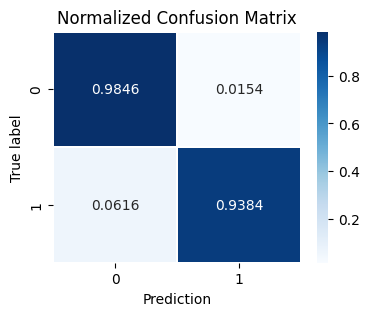


(Time taken: 11.21 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9582,0.9446,0.9581,0.9557,0.9557,0.9495,0.9594,0.9655,0.9717
ROC-AUC,0.9576,0.9398,0.9450,0.9484,0.9578,0.9470,0.9637,0.9633,0.9689


Refit to full training data and evaluate:

|| Accuracy: 0.9631 || ROC-AUC: 0.9610 ||



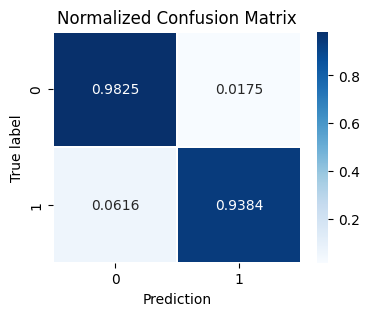


(Time taken: 11.12 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9475,0.9299,0.9381,0.9350,0.9515,0.9404,0.9376,0.9618,0.9613


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9513 ||



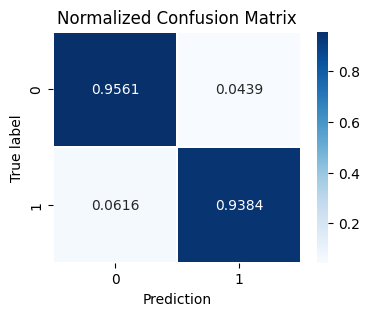


(Time taken: 6.42 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9511,0.9307,0.9476,0.9467,0.9446,0.9420,0.9543,0.9593,0.9627


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9531 ||



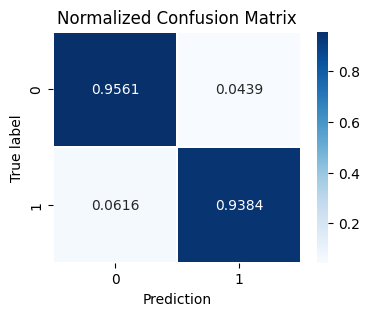


(Time taken: 5.68 secs)


In [25]:
run_experiment(model, 'rforest')

# AdaBoost

In [26]:
base_estimator = DecisionTreeClassifier(
    max_depth=6, 
    class_weight='balanced',
    random_state=SEED
)

model = AdaBoostClassifier(
    estimator=base_estimator, 
    n_estimators=50, 
    learning_rate=0.05,
    algorithm='SAMME',
    random_state=SEED
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9582,0.9446,0.9569,0.9557,0.9557,0.947,0.9581,0.9655,0.9717
ROC-AUC,0.9610,0.9367,0.9525,0.9526,0.9571,0.945,0.9647,0.9623,0.9702


Refit to full training data and evaluate:

|| Accuracy: 0.9631 || ROC-AUC: 0.9659 ||



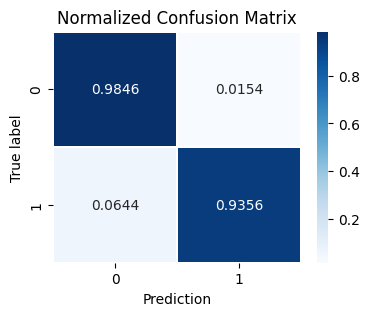


(Time taken: 14.23 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9582,0.9446,0.9569,0.9557,0.9557,0.947,0.9581,0.9655,0.9717
ROC-AUC,0.9615,0.9367,0.9513,0.9526,0.9566,0.948,0.9638,0.9622,0.9702


Refit to full training data and evaluate:

|| Accuracy: 0.9643 || ROC-AUC: 0.9660 ||



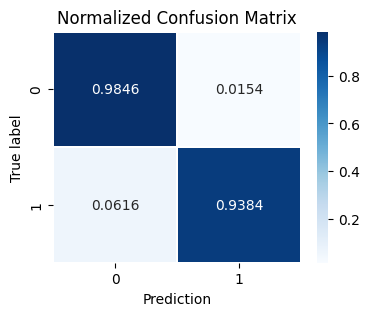


(Time taken: 15.11 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9503,0.9340,0.9537,0.9414,0.9453,0.9349,0.9428,0.9595,0.9608


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9431 ||



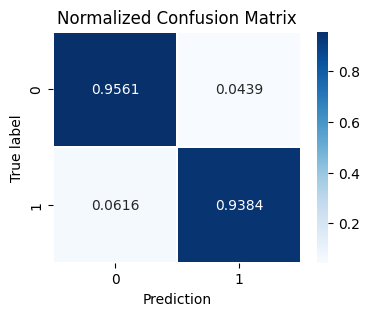


(Time taken: 5.38 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9425,0.9255,0.9438,0.9406,0.9401,0.9373,0.9433,0.9599,0.9592


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9456 ||



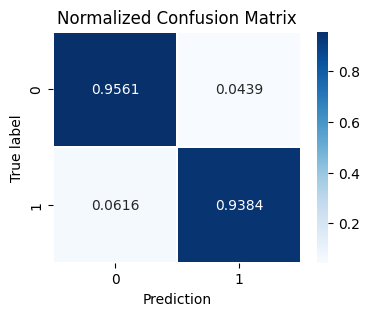


(Time taken: 3.76 secs)


In [27]:
run_experiment(model, 'adaboost')

# Hist-Gradient Boosting

In [28]:
categorical_features = [f for f in extended_features if f not in num_features]
train[categorical_features] = train[categorical_features].astype('category')
test[categorical_features] = test[categorical_features].astype('category')

In [29]:
HistGradientBoostingClassifier(
    learning_rate=0.02,
    max_iter=1000,
    max_depth=6,
    tol=2e-4,
    early_stopping=True,
    n_iter_no_change=25,
    validation_fraction=0.1,
    categorical_features="from_dtype",
    scoring=make_scorer(accuracy_score),
    class_weight='balanced',
    random_state=SEED
)

HistGradientBoostingClassifier(categorical_features='from_dtype',
                               class_weight='balanced', early_stopping=True,
                               learning_rate=0.02, max_depth=6, max_iter=1000,
                               n_iter_no_change=25, random_state=2024,
                               scoring=make_scorer(accuracy_score), tol=0.0002)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9582,0.9446,0.9569,0.9557,0.9557,0.947,0.9581,0.9655,0.9717
ROC-AUC,0.9610,0.9367,0.9525,0.9526,0.9571,0.945,0.9647,0.9623,0.9702


Refit to full training data and evaluate:

|| Accuracy: 0.9631 || ROC-AUC: 0.9659 ||



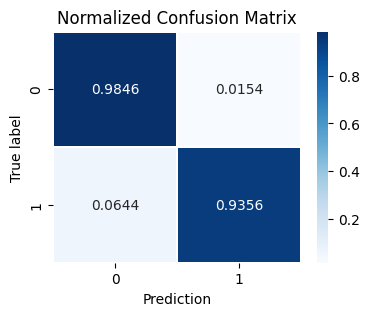


(Time taken: 14.23 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9582,0.9446,0.9569,0.9557,0.9557,0.947,0.9581,0.9655,0.9717
ROC-AUC,0.9615,0.9367,0.9513,0.9526,0.9566,0.948,0.9638,0.9622,0.9702


Refit to full training data and evaluate:

|| Accuracy: 0.9643 || ROC-AUC: 0.9660 ||



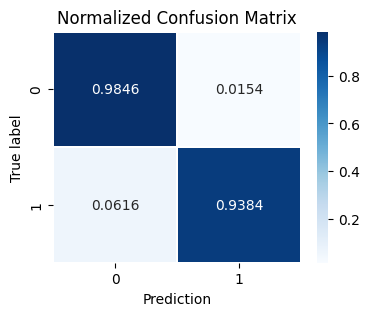


(Time taken: 15.02 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9503,0.9340,0.9537,0.9414,0.9453,0.9349,0.9428,0.9595,0.9608


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9431 ||



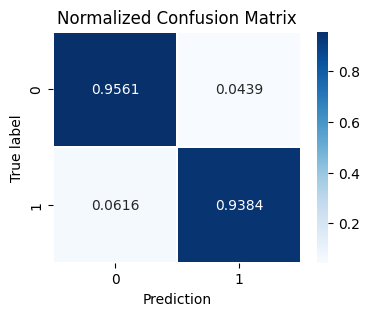


(Time taken: 8.92 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9425,0.9255,0.9438,0.9406,0.9401,0.9373,0.9433,0.9599,0.9592


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9456 ||



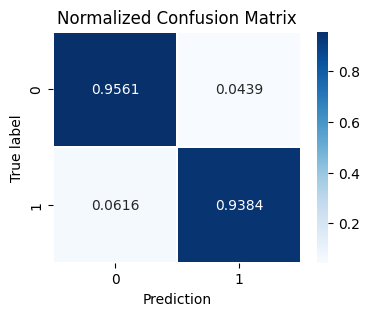


(Time taken: 5.52 secs)


In [30]:
run_experiment(model, 'histgradient')

# Multi-Layer Perceptron

In [31]:
mlpnn = MLPClassifier(
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate_init=2e-4,
    max_iter=1000,
    tol=1e-4,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=25,
    random_state=SEED
)

model = make_pipeline(
    StandardScaler(),
    mlpnn
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.8180,0.8364,0.8300,0.8608,0.8128,0.8313,0.8424,0.8608,0.8658
ROC-AUC,0.9043,0.8991,0.9021,0.9214,0.8828,0.9051,0.9097,0.9266,0.9338


Refit to full training data and evaluate:

|| Accuracy: 0.8462 || ROC-AUC: 0.9129 ||



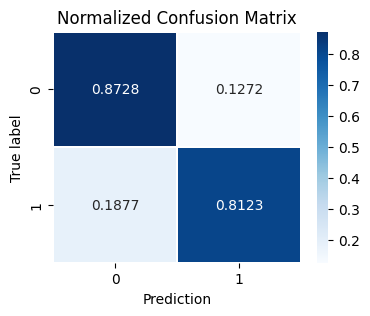


(Time taken: 62.40 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.941,0.9299,0.9433,0.9409,0.9397,0.9347,0.9372,0.9557,0.9532
ROC-AUC,0.953,0.9317,0.9451,0.9459,0.9489,0.9461,0.9491,0.9622,0.9663


Refit to full training data and evaluate:

|| Accuracy: 0.9496 || ROC-AUC: 0.9578 ||



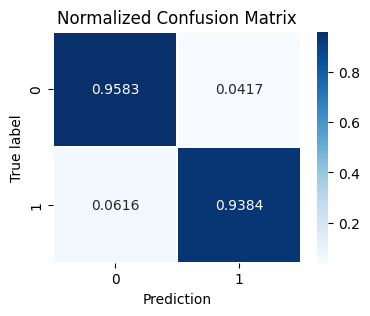


(Time taken: 18.90 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9360,0.9433,0.9372,0.9261,0.9569,0.9557
ROC-AUC,0.9493,0.9349,0.9400,0.9455,0.9539,0.9383,0.9473,0.9600,0.9632


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9550 ||



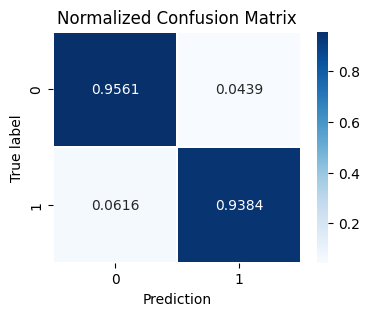


(Time taken: 15.23 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9473,0.9321,0.9445,0.9426,0.9493,0.9383,0.9472,0.9562,0.9633


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9544 ||



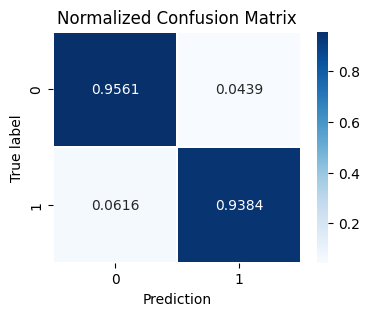


(Time taken: 13.02 secs)


In [32]:
run_experiment(model, 'mlpnn')